In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.holtwinters import Holt,SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
sales=pd.read_excel('CocaCola_Sales_Rawdata.xlsx',header=0,index_col=0,parse_dates=True)
sales

,Sales
Quarter,
Q1_86,1734.827000
Q2_86,2244.960999
Q3_86,2533.804993
Q4_86,2154.962997
Q1_87,1547.818996
Q2_87,2104.411995
Q3_87,2014.362999
Q4_87,1991.746998
Q1_88,1869.049999


In [3]:
sales.shape

(42, 1)

<AxesSubplot:xlabel='Quarter'>

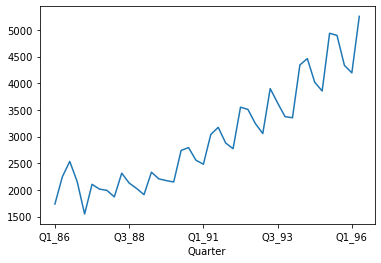

In [4]:
sales.Sales.plot()

array([[<AxesSubplot:title={'center':'Sales'}>]], dtype=object)

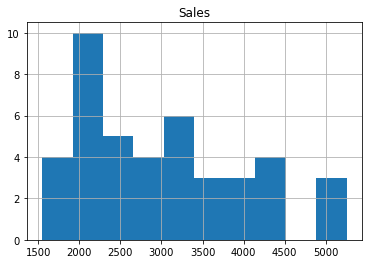

In [5]:
sales.hist()

<AxesSubplot:ylabel='Density'>

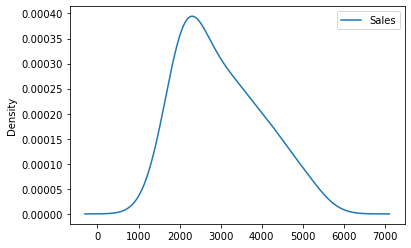

In [6]:
sales.plot(kind='kde')

In [7]:
# Seperation of Valaidation dataset
split=len(sales)-10
dataset,valdation=sales[:split],sales[split:]
dataset.to_csv('dataset.csv')
valdation.to_csv('validation.csv',header=None)
print('Dataset = %d, Validation =%d'%(len(dataset),len(valdation)))

Dataset = 32, Validation =10


In [8]:
valid=pd.read_csv('validation.csv')
valid

,Q1_94,3352.0
0,Q2_94,4342.0
1,Q3_94,4461.0
2,Q4_94,4017.0
3,Q1_95,3854.0
4,Q2_95,4936.0
5,Q3_95,4895.0
6,Q4_95,4333.0
7,Q1_96,4194.0
8,Q2_96,5253.0


## Persistance/Base Model

In [9]:
train=pd.read_csv('dataset.csv',header=0,index_col=0,parse_dates=True)

In [10]:
X=train.values
X=X.astype('float32')
train_size=int(len(X)*0.7)
train,test=X[:train_size],X[train_size:]
train.shape

(22, 1)

In [11]:
test.shape

(10, 1)

In [12]:
# Walk forward validation
history=[x for x in train]
prediction=list()

for i in range(len(test)):
    yhat=history[-1]
    prediction.append(yhat)
    # observation
    obs=test[i]
    history.append(obs)
    print('Predicted %.3f, Expected %.3f'% (yhat,obs))

Predicted 3039.523, Expected 3172.116
Predicted 3172.116, Expected 2879.001
Predicted 2879.001, Expected 2772.000
Predicted 2772.000, Expected 3550.000
Predicted 3550.000, Expected 3508.000
Predicted 3508.000, Expected 3243.860
Predicted 3243.860, Expected 3056.000
Predicted 3056.000, Expected 3899.000
Predicted 3899.000, Expected 3629.000
Predicted 3629.000, Expected 3373.000


In [13]:
#RMSE Value
rmse=sqrt(mean_squared_error(test,prediction))
print('RMSE Value = %.2f'%rmse)

RMSE Value = 409.41


## ARIMA Hyperparameters

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
def evaluate_arima_model(X,arima_order):
    history=[x for x in train]
    prediction=list()
    
    for t in range(len(test)):
        model=ARIMA(history,order=arima_order)
        model_fit=model.fit()
        yhat=model_fit.forecast()[0]
        prediction.append(yhat)
        history.append(test[t])
    rmse=sqrt(mean_squared_error(test,prediction))
    return rmse

In [16]:
# Evaluate p,d,q
def evaluate_model(dataset,p_values,d_values,q_values):
    dataset=dataset.astype('float32')
    best_score,best_cnfg=float('inf'),None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order=(p,d,q)
                try:
                    rmse=evaluate_arima_model(train,order)
                    if rmse<best_score:
                        best_score,best_cnfg=rmse,order
                    print('ARIMA %s, RMSE = %f'%(order,rmse))
                except:
                    continue
    print('Best ARIMA %s, RMSE = %.3f' % (best_cnfg,best_score))

In [17]:
p_values=range(0,3)
d_values=range(0,3)
q_values=range(0,3)

evaluate_model(train,p_values,d_values,q_values)

ARIMA (0, 0, 0), RMSE = 972.445712
ARIMA (0, 0, 1), RMSE = 679.521825
ARIMA (0, 0, 2), RMSE = 400.864851
ARIMA (0, 1, 0), RMSE = 416.517022
ARIMA (0, 1, 1), RMSE = 399.276702
ARIMA (0, 1, 2), RMSE = 354.489515
ARIMA (0, 2, 0), RMSE = 660.040654
ARIMA (0, 2, 1), RMSE = 440.013880
ARIMA (0, 2, 2), RMSE = 372.602885
ARIMA (1, 0, 0), RMSE = 458.636753
ARIMA (1, 0, 1), RMSE = 449.552009
ARIMA (1, 1, 0), RMSE = 411.880738
ARIMA (1, 1, 1), RMSE = 370.133777
ARIMA (1, 2, 0), RMSE = 627.141698
ARIMA (1, 2, 1), RMSE = 439.890953
ARIMA (2, 0, 0), RMSE = 463.500001
ARIMA (2, 1, 0), RMSE = 300.225338
ARIMA (2, 1, 1), RMSE = 273.763735
ARIMA (2, 2, 0), RMSE = 510.197536
ARIMA (2, 2, 1), RMSE = 319.139404
Best ARIMA (2, 1, 1), RMSE = 273.764


## Build model based on optimized values

In [18]:
model=ARIMA(X,order=(2,1,1))
model_fit=model.fit()
forecast=model_fit.forecast(10)[0]
forecast

array([3628.14901216, 3838.47235159, 3748.39176058, 3720.10532497,
       3864.23792135, 3951.33870771, 3941.99024784, 3977.97688742,
       4066.35151627, 4121.51712741])

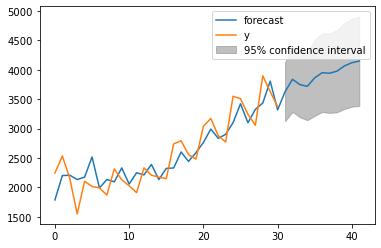

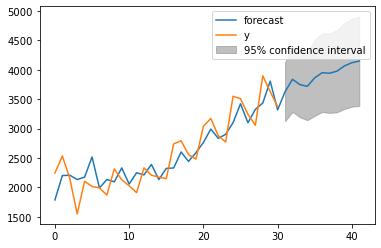

In [19]:
model_fit.plot_predict(1,42)

In [20]:
#Error on test data
val=pd.read_csv('validation.csv',header=None)
val

,0,1
0,Q1_94,3352.0
1,Q2_94,4342.0
2,Q3_94,4461.0
3,Q4_94,4017.0
4,Q1_95,3854.0
5,Q2_95,4936.0
6,Q3_95,4895.0
7,Q4_95,4333.0
8,Q1_96,4194.0
9,Q2_96,5253.0


In [21]:
rmse_val=sqrt(mean_squared_error(val[1],forecast))
rmse_val

650.0949638843601